Submit a job over Chicago using hyp3-sdk.

News article: https://news.wttw.com/2025/09/16/chicago-among-major-us-cities-are-slowly-sinking-study

Extra libraries required:

- jupyter-notebook
- hyp3_sdk
- geopandas

In [1]:
from hyp3_sdk import HyP3
from asf_enumeration import aria_s1_gunw
from shapely import Point
import geopandas as gpd
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm

# Interactive Frame Selection

In [7]:
chicago_pt = Point(-87.6324, 41.8832)
df_aoi = gpd.GeoDataFrame(geometry=[chicago_pt], crs='4326')

In [3]:
frames_over_point = aria_s1_gunw.get_frames(geometry=chicago_pt)
frames_over_point[0]

AriaFrame(id=2806, path=19, flight_direction='ASCENDING', polygon=<POLYGON ((-89.801 41.438, -90.114 42.626, -90.109 42.627, -90.197 42.958, -...>)

In [4]:
data = [f.__dict__ for f in frames_over_point]
def rename_key(key: str):
    return key if key != 'polygon' else 'geometry'

data = [{rename_key(k):v for k, v in d.items()} for d in data]
df_frames = gpd.GeoDataFrame(data, crs='4326')

In [5]:
df_frames.head()

,id,path,flight_direction,geometry
0,2806,19,ASCENDING,"POLYGON ((-89.8012 41.4378, -90.1137 42.6259, ..."
1,18782,121,ASCENDING,"POLYGON ((-84.6314 41.2115, -84.5885 41.0064, ..."
2,15405,99,DESCENDING,"POLYGON ((-86.8156 41.3525, -87.3664 41.4237, ..."


<Axes: >

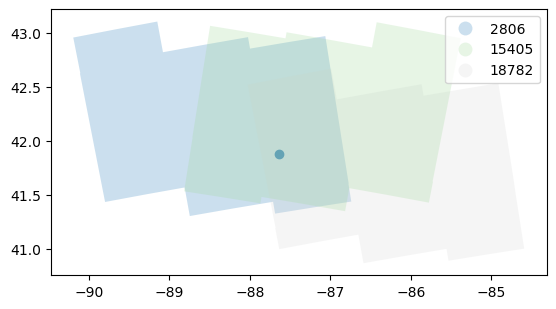

In [8]:
fig, ax = plt.subplots()

df_aoi.plot(ax=ax)
df_frames.plot(column='id', categorical=True, alpha=.25, ax=ax, legend=True, cmap='tab20c')

Below is a nice interactive map for exploring the tiles.

In [9]:
# df_frames.explore(column='id', alpha=.25, categorical=True)

# Get SLC Stack 

In [10]:
FRAME_ID = 18782 # the other frames of far less acquisition data as can be checked.

In [11]:
acquisitions_within_frame_id = aria_s1_gunw.get_acquisitions(FRAME_ID)
len(acquisitions_within_frame_id)

["'type': 'GEOMETRY_SIMPLIFICATION': 'report': 'Shape Simplified: shape of 22 simplified to 21 with proximity threshold of 0.0004'", "'type': 'REVERSE': 'report': Reversed polygon winding order"]


244

In [12]:
len(acquisitions_within_frame_id)

244

In [13]:
dates = sorted([acq.date for acq in acquisitions_within_frame_id])
dates[:3]

[datetime.date(2016, 11, 19),
 datetime.date(2016, 12, 13),
 datetime.date(2017, 1, 6)]

In [14]:
s = [1, 2, 3]
s[:-1]

[1, 2]

## Enumerate Dates

In [15]:
N_NEIGHBORS = 3
date_pairs = [{'ref_date': ref_date,
               'sec_date': sec_date} for k, ref_date in enumerate(reversed(dates)) for sec_date in dates[-k - N_NEIGHBORS - 1:-k - 1]]
date_pairs[:8]

[{'ref_date': datetime.date(2025, 8, 28),
  'sec_date': datetime.date(2025, 7, 23)},
 {'ref_date': datetime.date(2025, 8, 28),
  'sec_date': datetime.date(2025, 8, 4)},
 {'ref_date': datetime.date(2025, 8, 28),
  'sec_date': datetime.date(2025, 8, 16)},
 {'ref_date': datetime.date(2025, 8, 16),
  'sec_date': datetime.date(2025, 7, 11)},
 {'ref_date': datetime.date(2025, 8, 16),
  'sec_date': datetime.date(2025, 7, 23)},
 {'ref_date': datetime.date(2025, 8, 16),
  'sec_date': datetime.date(2025, 8, 4)},
 {'ref_date': datetime.date(2025, 8, 4),
  'sec_date': datetime.date(2025, 6, 29)},
 {'ref_date': datetime.date(2025, 8, 4),
  'sec_date': datetime.date(2025, 7, 11)}]

# Submit

In [16]:
hyp3_endpoint = HyP3()
now_str = datetime.now().strftime("%Y-%m-%d")
now_str

'2025-09-26'

In [17]:
job_name = f'{FRAME_ID}_{now_str}'
job_name

'18782_2025-09-26'

In [18]:
for dp in tqdm(date_pairs[40:42]):
    hyp3_endpoint.submit_aria_s1_gunw_job(str(dp['ref_date']), str(dp['sec_date']), FRAME_ID, job_name)

100%|█████████████████████████████| 2/2 [00:00<00:00,  3.06it/s]


# Track

In [19]:
jobs = hyp3_endpoint.find_jobs(#start=submit_time_approx,
                               user_id='cmarshak', 
                               job_type='ARIA_S1_GUNW',
                               name=job_name
)
print(jobs)

6 HyP3 Jobs: 0 succeeded, 0 failed, 4 running, 2 pending.


In [20]:
jd = [j.to_dict() for j in jobs]
jd[0]

{'user_id': 'cmarshak',
 'job_parameters': {'secondary_date': '2025-03-01',
  'frame_id': 18782,
  'reference_date': '2025-03-25'},
 'job_id': '7be11cab-dc52-4568-b8fb-b834bee182fd',
 'credit_cost': 60,
 'job_type': 'ARIA_S1_GUNW',
 'request_time': '2025-09-26T22:05:18+00:00',
 'status_code': 'PENDING',
 'priority': 9760,
 'name': '18782_2025-09-26'}